In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
%matplotlib notebook
import zmq
import threading
import ipywidgets as ipw
from IPython.display import display
import time
from dipde.interfaces import PopulationInterface
import ipywidgets as ipw
from IPython.display import display, clear_output
import numpy as np 
from dipde.internals.internalpopulation import InternalPopulation
from dipde.internals.externalpopulation import ExternalPopulation
from dipde.internals.simulationconfiguration import SimulationConfiguration
from dipde.internals.network import Network
from dipde.internals.simulation import Simulation
from dipde.internals.connection import Connection as Connection
import scipy.stats as sps
from dipde.interfaces.zmq import RequestFiringRate, ReplyServerThread
from dipde.interfaces.zmq import PublishCallbackConnect, CallbackSubscriberThread
from dipde.interfaces.zmq import context as zmq_context
import time
import logging
import os
import dipde
assert dipde.__version__ == '0.2.1'
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import ipywidgets as ipw
import logging
from IPython.display import HTML
from dipde.interfaces import PopulationInterface
logging.disable(logging.CRITICAL)
import traitlets
import time
import threading
logging.disable(logging.CRITICAL)

context = zmq.Context()

t0 = 0.
dt = .001
dv = .001
v_max = .02
tf = .2
tau_m=.02
weights=.005
bgfr = 100




        
class App(threading.Thread):
    
    def __init__(self):
        super(App, self).__init__()
        

        self.daemon = True
        
        self.fig, ax = plt.subplots(1,1, figsize=(5,5))
        
        def update_callback(n):
            time.sleep(.1)

        bgfr = RequestFiringRate(5555)
        b1 = ExternalPopulation(bgfr)
        i1 = InternalPopulation(v_min=0, tau_m=tau_m, v_max=v_max, dv=dv, update_method='approx')
        b1_i1 = Connection(b1, i1, 1, weights=weights)
        
        network = dipde.Network([b1, i1], [b1_i1], update_callback=update_callback)
        simulation_configuration = dipde.SimulationConfiguration(dt, tf, t0=t0, checkpoint_period=.2)
        
        window_size = .1
        
        i1.plot(xlim=(0,window_size), ax=ax, ylim=(0,8), color='r', show=True)
        def checkpoint_callback(s):
            p = s.network.population_list[1]
            
            window_points = int(window_size/dt)
            
            if len(p.t_record) < window_points:
            
                t_vals = p.t_record
                y_vals = p.firing_rate_record
            else:
                t_vals = p.t_record[-window_points:]
                y_vals = p.firing_rate_record[-window_points:]
            
            ax.lines[0].set_xdata(t_vals)
            ax.lines[0].set_ydata(y_vals)
            if t_vals[-1] < window_size:
                t_max = window_size
            else:
                t_max = t_vals[-1]*1.05
                    
            ax.set_xlim((t_vals[0],t_max))
            
            self.fig.canvas.draw()
        

        self.simulation = dipde.Simulation(network=network, simulation_configuration=simulation_configuration, checkpoint_callback=checkpoint_callback)
    def run(self):

        self.simulation.run()



<IPython.core.display.Javascript object>


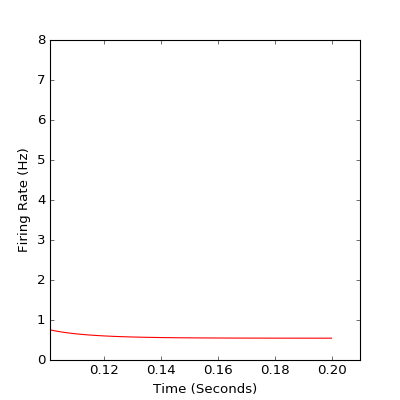

In [3]:


pb = ipw.IntSlider(min=0, max=100, value=50)
display(pb)

from dipde.interfaces.zmq import WidgetReplyServerThread, RequestFiringRate


app = WidgetReplyServerThread(pb, port=5555)
app.start()



app2 = App()
app2.start()
# t = threading.Thread(target=app2.start)
# _ = t.start()